## Import libraries

In [1]:
!pip install imutils

In [30]:
import os
import cv2
import numpy as np
import random
import keras

from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import plot_confusion_matrix
import matplotlib.patches as mpatches
import pandas as pd

## sample inage

### With Mask

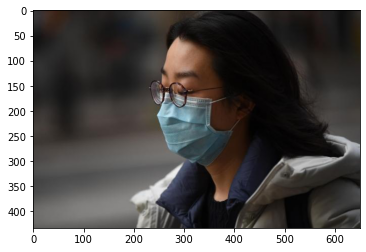

In [3]:
images_withMask = os.listdir("./New Masks Dataset/Train/Mask")
sample_img_withMask = random.choice(images_withMask)
image = load_img("./New Masks Dataset/Train/Mask/"+sample_img_withMask)
plt.imshow(image)

### Without Mask

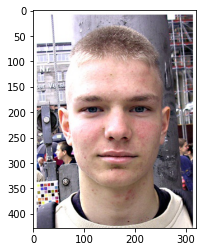

In [4]:
images_withoutMask = os.listdir("./New Masks Dataset/Train/Non Mask")
sample_img_withoutMask = random.choice(images_withoutMask)
image = load_img("./New Masks Dataset/Train/Non Mask/"+sample_img_withoutMask)
plt.imshow(image)

## Data Augmentation

In [5]:
img_width=224
img_height=224

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 50
BS = 32
train_data_dir="./New Masks Dataset/Train"
test_data_dir="./New Masks Dataset/Validation"

all_train_imagePaths = list(paths.list_images(train_data_dir))
all_test_imagePaths = list(paths.list_images(test_data_dir))
train_data = []
train_labels = []
test_data = []
test_labels = []

In [7]:
# loop over the image paths
for imagePath in all_train_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath,color_mode='rgb', target_size=(224, 224),interpolation='bicubic')
	image = img_to_array(image)
	image = preprocess_input(image)
    

	# update the data and labels lists, respectively
	train_data.append(image)
	train_labels.append(label)

In [9]:
# loop over the image paths
for imagePath in all_test_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath,color_mode='rgb', target_size=(224, 224),interpolation='bicubic')

	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	test_data.append(image)
	test_labels.append(label)

In [10]:
def convert_data_labels(data,labels):
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)

  # perform one-hot encoding on the labels
  lb = LabelBinarizer()
  labels = lb.fit_transform(labels)
  labels = to_categorical(labels)
  return  data,labels

In [11]:
train_data,train_labels = convert_data_labels(train_data,train_labels)
test_data,test_labels = convert_data_labels(test_data,test_labels)

In [12]:
print("==================================")
print("Size of train dataset : ",train_data.shape[0])
print("==================================")
print("Size of test dataset : ",test_data.shape[0])
print("==================================")

Size of train dataset :  600
Size of test dataset :  306


In [13]:
# train datagen
train_datagen = ImageDataGenerator(
                  rotation_range=90,
                  zoom_range=[0.5,1.0],
                  width_shift_range=0.3,
                  height_shift_range=0.3,
                  shear_range=0.15,
                  horizontal_flip=True,
                  vertical_flip=True,
                  brightness_range=[0.2,1.0],
                  fill_mode="nearest")

train_generator = train_datagen.flow(train_data, train_labels, batch_size=BS)

# #  Model Building

### Load MobileNetV2

In [14]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [15]:
# construct the head of the model that will be placed on top of the the base model
headModel = mobilenet.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [16]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=mobilenet.input, outputs=headModel)

In [17]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Done !!")

[INFO] compiling model...
Done !!


In [18]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in mobilenet.layers:
	layer.trainable = False

In [19]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

### Callback Function 

In [20]:
# checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
# # history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint
checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/fmd_model.h5",
                             monitor='val_loss',
                             mode='auto',
                             save_best_only=True,
                             verbose=1)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# TBoard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

In [21]:
callbacks = [earlystop , checkPoint, learning_rate_reduction]

## Model Fitting 

In [22]:
start_time=timer(None)
classifier = model.fit(
    train_datagen.flow(train_data, train_labels, batch_size=BS), 
    epochs=EPOCHS,
    validation_data=(test_data,test_labels),
    validation_steps=len(test_data)//BS,
    steps_per_epoch=len(train_data)//BS,
    callbacks=callbacks
)
timer(start_time)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7535
Epoch 1: val_loss improved from inf to 0.45349, saving model to /content/sample_data\fmd_model.h5
18/18 [==============================] - 207s 8s/step - loss: 0.5653 - accuracy: 0.7535 - val_loss: 0.4535 - val_accuracy: 0.8856 - lr: 1.0000e-04
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9225
Epoch 2: val_loss did not improve from 0.45349
18/18 [==============================] - 144s 8s/step - loss: 0.2662 - accuracy: 0.9225 - val_loss: 0.4704 - val_accuracy: 0.7614 - lr: 1.0000e-04
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9665
Epoch 3: val_loss did not improve from 0.45349

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
18/18 [==============================] - 145s 8s/step - loss: 0.1397 - accuracy: 0.9665 - val_loss: 0.6411 - val_accuracy: 0.6536 - lr: 1.0000e-04
Epoch 4/

## Training Loss and Accuracy Visualization 

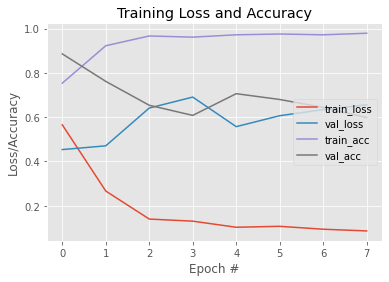

In [23]:
# plot the training loss and accuracy
plt.style.use("ggplot")
N = 10 # epochs number
plt.figure()
plt.plot( classifier.history["loss"], label="train_loss")
plt.plot( classifier.history["val_loss"], label="val_loss")
plt.plot( classifier.history["accuracy"], label="train_acc")
plt.plot( classifier.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

### Find Prediction

In [24]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_data, batch_size=BS)

[INFO] evaluating network...


In [25]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

### Find Accuracy

In [26]:
# check accuracy
val_loss,val_acc = model.evaluate(test_data,test_labels)
print("=======================================================")
print("Accuracy is : ",val_acc)
print("=======================================================")
print("Loss is : ",val_loss)
print("=======================================================")

10/10 [==============================] - 28s 950ms/step - loss: 0.4535 - accuracy: 0.8856
Accuracy is :  0.8856208920478821
Loss is :  0.4534907042980194


### Classification Report

In [27]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       153
           1       0.86      0.92      0.89       153

    accuracy                           0.89       306
   macro avg       0.89      0.89      0.89       306
weighted avg       0.89      0.89      0.89       306



In [32]:
plot_confusion_matrix(classifier, test_labels.argmax(axis=1), predIdxs)


# Saving plot to output file


plt.title("Naive Bayes Confusion Matrix",pad=40,fontweight="bold")
plt.savefig("NaiveBayes-ConfusionMatrix.pdf")
os.chdir("..")


plt.show() 

ValueError: plot_confusion_matrix only supports classifiers